In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
yelp_train = pd.read_csv('yelp242_train.csv')
yelp_test = pd.read_csv('yelp242_test.csv')

In [3]:
y_train = yelp_train['stars']
y_test = yelp_test['stars']
X_train = yelp_train.drop(['stars'], axis=1)
X_test = yelp_test.drop(['stars'], axis=1)

In [4]:
# Change data's form
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

X_train_enc = X_train.select_dtypes(include='object').apply(labelencoder.fit_transform)
X_test_enc = X_test.select_dtypes(include='object').apply(labelencoder.fit_transform)

X_train_new = pd.concat([X_train.drop(X_train_enc.columns, axis=1), X_train_enc], axis=1)
X_test_new = pd.concat([X_test.drop(X_test_enc.columns, axis=1), X_test_enc], axis=1)

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf':[5],
               'min_samples_split': [20],
               'max_depth':[30],
               'random_state':[88]}

dtr = DecisionTreeRegressor()
dtr_cv_r2 = GridSearchCV(dtr, param_grid = grid_values, scoring='r2', cv=10, verbose=1)
dtr_cv_r2.fit(X_train_new, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.020...
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
            

In [6]:
r2 = dtr_cv_r2.cv_results_['mean_test_score'] 
ccp = dtr_cv_r2.cv_results_['param_ccp_alpha'].data

#pd.DataFrame({'ccp alpha' : ccp, 'Validation R2' : r2}).head(20)

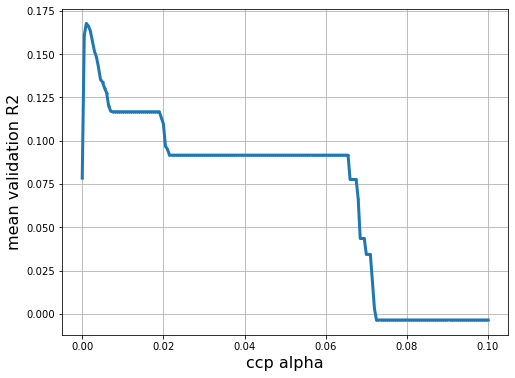

In [7]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation R2', fontsize=16)
plt.scatter(ccp, r2, s=2)
plt.plot(ccp, r2, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [8]:
print('Grid best parameter ccp_alpha (max. R2): ', dtr_cv_r2.best_params_['ccp_alpha'])
print('Grid best score (R2): ', dtr_cv_r2.best_score_)

Grid best parameter ccp_alpha (max. R2):  0.001
Grid best score (R2):  0.16768062671476475


## Regression Tree Model 

In [9]:
dtr1 = DecisionTreeRegressor(min_samples_leaf=5, 
                              ccp_alpha=0.001,
                              random_state = 88)

Node count =  59


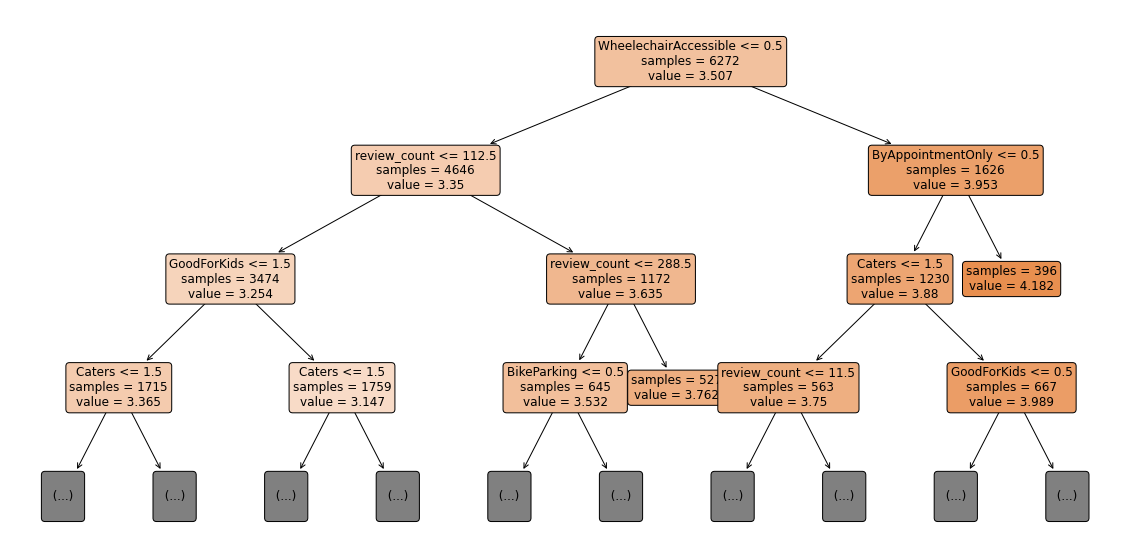

In [10]:
from sklearn.tree import plot_tree

print('Node count = ', dtr_cv_r2.best_estimator_.tree_.node_count)
plt.figure(figsize=(20,10))
plot_tree(dtr_cv_r2.best_estimator_,
          feature_names=X_train_new.columns,
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()

## OSR2

In [11]:
dtr1 = dtr1.fit(X_train_new, y_train)
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [12]:
print('OSR2:', OSR2(dtr1, X_test_new, y_test, y_train))

OSR2: 0.14107439745087524


## MAE (mean absolute error)

In [13]:
from sklearn.metrics import mean_absolute_error
dt_predictions = dtr1.predict(X_test_new)
dt_mae = mean_absolute_error(y_test, dt_predictions)
print(dt_mae)

0.612850073081544


## Predictions of fourOrAbove

In [14]:
def convert_to_binary(predictions):
    binary_predictions = np.zeros(predictions.shape)
    binary_predictions[predictions >= 4] = 1
    return binary_predictions.astype(int)

dt_predictions = dtr1.predict(X_test_new)
convert_to_binary(dt_predictions)

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
count_of_zeros = sum(1 for i in convert_to_binary(dt_predictions) if i == 0)
print(count_of_zeros)

count_of_ones = sum(1 for i in convert_to_binary(dt_predictions) if i == 1)
print(count_of_ones)

2456
232


In [16]:
from sklearn.metrics import confusion_matrix

y_test2 = convert_to_binary(y_test)
y_pred = convert_to_binary(dtr1.predict(X_test_new))
cm = confusion_matrix(y_test2, y_pred)

print ("Confusion Matrix : \n", cm) 

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Confusion Matrix : 
 [[1474   46]
 [ 982  186]]
Accuracy is: 0.6176
TPR is: 0.1592
FPR is: 0.0303
